In [67]:
%cd ~/github/agn_lf/
import source.astro_functions as af
import source.table_functions as tf
import source.lf_xi2 as xi2
import source.vmax as vmax
import source.utils as utils
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.interpolate import interp1d as intp
import astropy.table as table
import astropy.units as u
import source.selection_criteria as sc

/Users/runburg/github/agn_lf


In [2]:
catalog = table.Table.read('./data/master_cat_irac3_mips24')

bands = np.array([3.6, 4.5, 5.8, 8, 24])
flux36 = 'f_ap_irac_i1'
flux45 = 'f_ap_irac_i2'
flux58 = 'f_ap_irac_i3'
flux80 = 'f_ap_irac_i4'
flux240 = 'f_mips_24'
# print(catalog[flux58][catalog[flux58] < 0])
never_nan = (np.nan_to_num(catalog[flux58], nan=-99) > 0) & (np.nan_to_num(catalog[flux80], nan=-99) > 0) #& (np.nan_to_num(catalog['zspec'], nan=-99) > 0)
selected_agn = sc.select_ir(catalog[never_nan], flux36, flux45, flux58, flux80, selection_cuts='lacy05')
ct_lacy = catalog[never_nan][selected_agn]
ct_lacy = ct_lacy[(np.nan_to_num(ct_lacy['z1_median'], nan=-99) > 0 ) | (np.nan_to_num(ct_lacy['zspec'], nan=-99) > 0)][flux36, flux45, flux58, flux80, flux240]

In [3]:
import seaborn as sns
sns.set_theme(style="whitegrid")

In [4]:
means = np.array(list(ct_lacy.groups.aggregate(np.mean)[0]))
stds = np.array(list(ct_lacy.groups.aggregate(np.std)[0]))


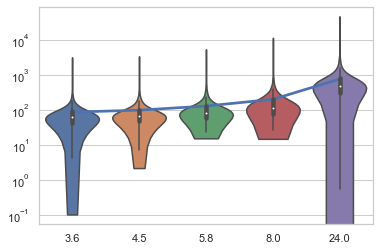

In [5]:
# ct_lacy["Band"] = [flux36, flux45, flux58, flux80, flux240]
ct = ct_lacy.to_pandas()
ct.columns = bands
ax = sns.pointplot(data=ct, ci=None)
ax = sns.violinplot(data=ct, scale='count', gridsize=500, cut=.2)

ax.set_yscale('log')
plt.savefig('./output/violin_sed_ir.png')

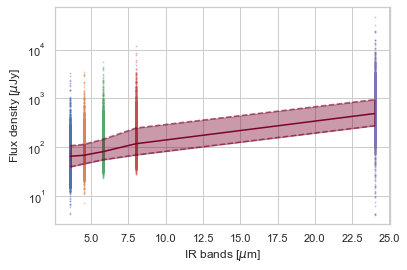

In [6]:
fig, ax = plt.subplots()
# means = np.mean(ct_lacy, axis=1)
bands = np.array([3.6, 4.5, 5.8, 8, 24])
color = 'xkcd:bordeaux'
# ax.plot(bands, means, color=color)
# ax.plot(bands, means - stds, color=color, alpha=0.6)
# ax.plot(bands, means + stds, color=color, alpha=0.6)
# ax.fill_between(bands, means + stds, means - stds, color=color, alpha=0.4)
mean, up, down = [], [], []
for num, col in zip(bands, ct_lacy.colnames):
    ax.scatter([num]*len(ct_lacy), ct_lacy[col], s=1, alpha=0.3)
    sortcol = np.sort(ct_lacy[col])
    num = len(sortcol)
    mean.append(sortcol[num//2])
    up.append(sortcol[int(num * 0.8)])
    down.append(sortcol[int(num * 0.2)])
    
ax.plot(bands, mean, color=color)
ax.plot(bands, up, '--', color=color, alpha=0.6)
ax.plot(bands, down, '--', color=color, alpha=0.6)
ax.fill_between(bands, up, down, color=color, alpha=0.4)
ax.set_xlabel(r'IR bands [$\mu$m]')
ax.set_ylabel(r'Flux density [$\mu$Jy]')
ax.set_yscale('log')
fig.savefig('./output/sed_ir.png')

In [7]:
means, stds, means - stds

(array([ 87.67373659,  99.69716162, 130.72178898, 203.99493744,
        775.46330741]),
 array([ 117.16707612,  146.03829149,  214.73702625,  362.69216916,
        1342.37051778]),
 array([ -29.49333953,  -46.34112986,  -84.01523728, -158.69723172,
        -566.90721037]))

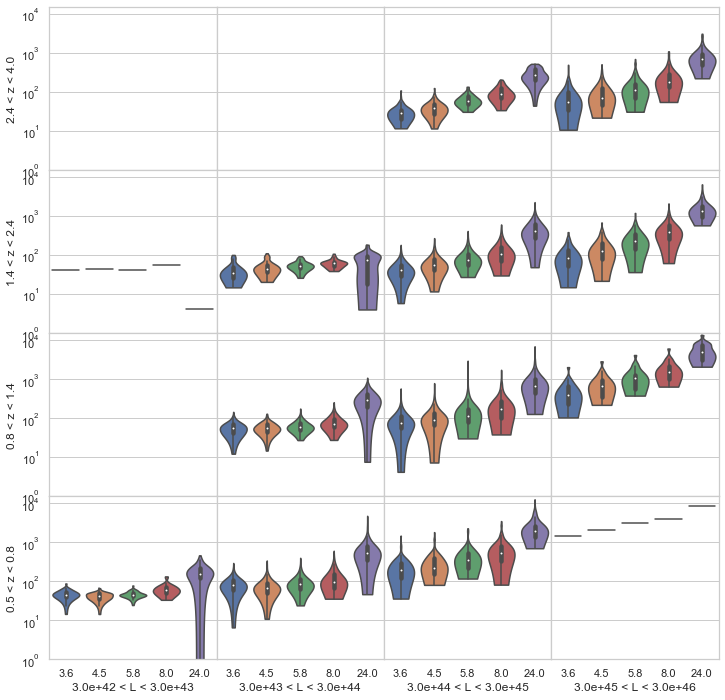

In [8]:
z_sample_min = 0.5
z_sample_max = 4
l_sample_min = 3e42 #erg/s
l_sample_max = 3e46 #erg/s 

cosmo = af.setup_cosmology()
wavelength = 5.8
unit_conversion = 3 / wavelength * 1e-15

num_bins_z = 5
num_bins_l = 5
# redshift range 
z_bins = np.logspace(np.log10(z_sample_min), np.log10(z_sample_max), num=num_bins_z)
# print(z_bins)
l_bins = np.logspace(np.log10(l_sample_min), np.log10(l_sample_max), num=num_bins_l)

cato = catalog[never_nan][selected_agn]
cato = cato[(np.nan_to_num(cato['z1_median'], nan=-99) > 0 ) | (np.nan_to_num(cato['zspec'], nan=-99) > 0)]

fig, axs = plt.subplots(nrows=num_bins_z-1, ncols=num_bins_l-1, figsize=(12, 12), sharex=True, sharey=True, gridspec_kw={'hspace': 0, 'wspace': 0})
spectral_index = np.log10(cato[flux240].data/cato[flux58].data) / np.log10(24/5.8)

z = np.array([row['zspec'] if row['zspec'] > 0 else row['z1_median'] for row in cato])  
l = 4 * np.pi * cosmo.luminosity_distance(z).to(u.cm).value**2 * cato[flux58].data * unit_conversion * (1 + z)**(-1 + spectral_index)

for i in range(num_bins_z - 1):
    for j in range(num_bins_l - 1):
        inbin = (l > l_bins[j]) & (l < l_bins[j+1]) & (z > z_bins[i]) & (z < z_bins[i+1])
        ax = sns.violinplot(data=ct[inbin], scale='count', gridsize=500, cut=0, bw=0.5, ax=axs[len(z_bins)-2-i, j])

for ax in axs.flatten():
    ax.set_yscale('log')
    ax.set_ylim(bottom=1)
    
for i, ax in enumerate(reversed(axs[:, 0])):
    lab = f"{z_bins[i]:.1f} < z < {z_bins[i+1]:.1f}"
    ax.set_ylabel(lab)

for i, ax in enumerate(axs[-1]):
    lab = f"{l_bins[i]:.1e} < L < {l_bins[i+1]:.1e}"
    ax.set_xlabel(lab)

In [9]:
xservs_catalog = table.Table.read('./data/tableA.v01.fits')
bands = ['Soft', 'Hard']
soft = 'SB_FLUX'
hard = 'HB_FLUX'
full = 'FB_FLUX'
never_nan = (np.nan_to_num(xservs_catalog[soft], nan=-99) > 0) & (np.nan_to_num(xservs_catalog[hard], nan=-99) > 0) & (np.nan_to_num(xservs_catalog[full], nan=-99) > 0) & ((np.nan_to_num(xservs_catalog['ZPHOT'], nan=-99) > 0) | (np.nan_to_num(xservs_catalog['ZSPEC'], nan=-99) > 0))
xscat = xservs_catalog[never_nan][soft, hard]

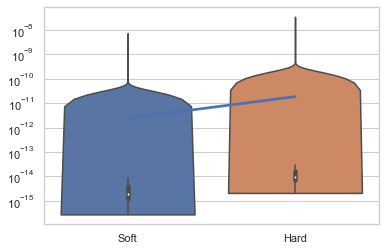

In [10]:
ct = xscat.to_pandas()
ct.columns = bands
ax = sns.pointplot(data=ct, ci=None)
ax = sns.violinplot(data=ct, scale='count', gridsize=1000, cut=0)

ax.set_yscale('log')
plt.savefig('./output/violin_sed_xray.png')

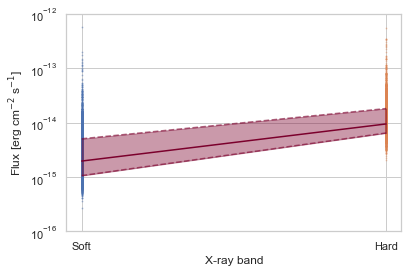

In [11]:
fig, ax = plt.subplots()
mean, up, down = [], [], []
for num, col in zip([0, 1], xscat.colnames):
    ax.scatter([num]*len(xscat), xscat[col], s=1, alpha=0.3)
    sortcol = np.sort(xscat[col])
    num = len(sortcol)
    mean.append(sortcol[num//2])
    up.append(sortcol[int(num * 0.8)])
    down.append(sortcol[int(num * 0.2)])

color = 'xkcd:bordeaux'
ax.plot([0, 1], mean, color=color)
ax.plot([0, 1], up, '--', color=color, alpha=0.6)
ax.plot([0, 1], down, '--', color=color, alpha=0.6)
ax.fill_between(bands, up, down, color=color, alpha=0.4)
ax.set_yscale('log')
ax.set_ylim(bottom=1e-16, top=1e-12)
ax.set_xlabel('X-ray band')
ax.set_ylabel(r'Flux [erg cm$^{-2}$ s$^{-1}$]')
fig.savefig('./output/sed_xray.png')

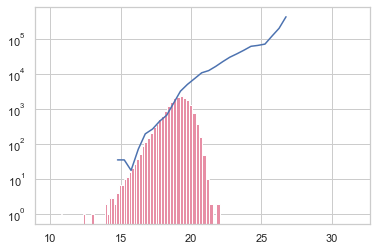

In [150]:
tab = table.Table(catalog)
mags = tab['m_ap_irac_i3'] - 2.5 * np.log10(tab['f_ap_irac_i3']/tab['f_ap_irac_i2'])
fig, ax = plt.subplots()
bins = np.logspace(1, 1.5, num=100)
histo, bins, _ = ax.hist(mags.filled().data, bins=bins, color='xkcd:pig pink')
ashby = np.loadtxt('./data/ashby_uds_corrected_counts.csv', delimiter=',').T
match_lower = 0.6
ax.plot(ashby[0], ashby[1] * match_lower)
ax.set_yscale('log')
# ax.set_xscale('log')


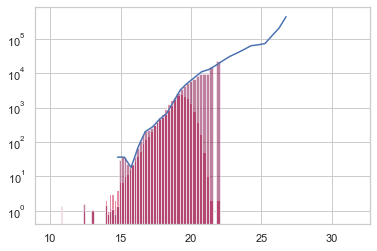

In [151]:
ashby_fn = intp(ashby[0], ashby[1] * match_lower, kind='quadratic', fill_value=1, bounds_error=False)
bin_centers = (bins[1:] + bins[:-1]) / 2
correction_coeffs = histo / ashby_fn(bin_centers) 
# print(correction_coeffs)
crctn_fn = intp(bin_centers, correction_coeffs, bounds_error=False, fill_value=1)
# ax.plot(bin_centers, histo/correction_coeffs, color='xkcd:wine')
ax.hist(mags.filled().data, bins=bins, color='xkcd:wine', alpha=0.5, weights=1/crctn_fn(mags.filled().data))
fig

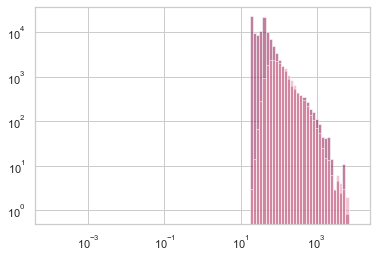

In [152]:
fig, ax = plt.subplots()
corrected_fluxes = tab['f_ap_irac_i3'].filled().data #/ crctn_fn(tab['m_ap_irac_i3'].filled().data)
bins = np.logspace(-4, 4, num=100)
ax.hist(corrected_fluxes, color='xkcd:wine', alpha=0.5, bins=bins, weights=1/crctn_fn(mags.filled().data))
ax.hist(tab['f_ap_irac_i3'].filled().data, color='xkcd:pig pink', alpha=0.5, bins=bins)
ax.set_xscale('log')
ax.set_yscale('log')